## 0. INTRODUCTION

### 0.1 Thank you, Andrej!

These scripts are inspired by [_Andrej Karpathy_'s Youtube Playlist](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) on Neuran Networks. \
The content will change as soon as I learn something new about the topics. \
Really excited to start! Wish you all could appreciate this content. \
\
You can find here his related project: [micrograd](https://github.com/karpathy/micrograd).

### 0.2 What is MLP

I want to build a [MultiLayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron). \
I'm talking about a fundamental type of Feedforward Neuran Network, proposed for the first time in 1958 by [Frank Rosenblatt](https://en.wikipedia.org/wiki/Frank_Rosenblatt).

### 0.3 Summary

* [0. INTRODUCTION](#0-introduction)
    * [0.1 Thank you, Andrej!](#0.1-Thank-you,-Andrej!)
    * [0.2 What is MLP](#0.2-What-is-MLP)
    * [0.3 Summary](#0.3-Summary) $\leftarrow$ *you are here!*
* [1. STARTING CODING WITH VIBES](#1-starting-coding-with-vibes)
    * [1.1 Importing libraries](#1.1-Importing-libraries)
    * [1.2 Building *Value* class](#1.2-Building-Value-class)
    * [1.3 Visualize how gradient works](#1.3-Visualize-how-gradient-works)
    * [1.4 PyTorch example](#1.4-PyTorch-example)
* [2. BUILD MAP](#2-build-mlp)
    * [2.1 Building *Neuron* class](#21-build-neuron-class)
    * [2.2 Building *Layer* class](#22-build-layer-class)
    * [2.3 Building *MLP* class](#23-build-mlp-class)
    * [2.4 Loss function](#24-loss-function)
    * [2.5 Visualize a MLP using Digraph](#25-visualize-a-mlp-using-digraph)
    * [2.6 How minimize loss function works](#26-how-minimize-loss-function-works)
    * [2.7 Minimize loss function](#27-minimize-loss-function)
    * [2.8 What happen if I don't update gradient every epoch](#28-what-happen-if-i-dont-update-gradient-every-epoch)
    * [2.9 What happen when I change learning rate](#29-what-happen-when-i-change-learning-rate)
      * [2.9.1 Learning rate](#291-learning-rate) $\eta \leq 0.1$
      * [2.9.2 Learning rate](#292-learning-rate) $\eta \in \{0.2, 0.4, 0.6, 0.8, 1.0\}$
      * [2.9.3 Learning rate](#293-learning-rate) $\eta \in \{0.1, 0.2, 0.3, 0.4, 0.5\}$
    * [2.10 Learning rate decay](#210-learning-rate-decay)
    * [2.11 Adaptive Learning Rate](#211-adaptive-learning-rate)

## 1. STARTING CODING WITH VIBES
(and not vibe coding) sorry andrej :)

### 1.1 Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import torch

### 1.2 Building _Value_ class

This class allow me to use a backward function to update gradient values

In [2]:
class Value:
    def __init__(self, data, _children = (), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._prev = _children
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        for node in reversed(topo):
            node._backward()

    def zero_grad(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        for node in reversed(topo):
            node.grad = 0.0


    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += res.grad
            other.grad += res.grad
        res._backward = _backward

        return res
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * res.grad
            other.grad += self.data * res.grad
        res._backward = _backward

        return res
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, number):
        assert isinstance(number, (int, float)), 'Not implemented yet!'

        res = Value(self.data ** number, (self, ), f'^{number}')

        def _backward():
            self.grad += (number * (self.data)**(number-1)) * res.grad
        res._backward = _backward
        
        return res

    def __truediv__(self, other):
        return self * (other)**-1
    
    def __rtruediv__(self, other):
        return other * (self)**-1

    def relu(self):
        res = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')

        def _backward():
            self.grad += (res.data > 0) * res.grad
        res._backward = _backward

        return res
    
    def tanh(self):
        t = np.tanh(self.data)
        res = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * res.grad
        res._backward = _backward

        return res

    def exp(self):
        res = Value(np.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += res.data * res.grad
        res._backward = _backward

        return res

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    

### 1.3 Visualize how gradient works

In [3]:
def trace(root):
    nodes = set()
    edges = set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)
    
    build(root)
    return nodes, edges

In [4]:
def draw(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{%s data: %.4f | grad: %.4f}' % (n.label + ' | ' if n.label != '' else '', n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

_Example_

In [ ]:
a = Value(2, label='a')
b = a + 2; b.label='b'
c = b ** 2; c.label='c'
e = Value(3, label='e')
d = c - e; d.label='d'
g = e - c; g.label='g'
f = d.relu() + g.relu(); f.label='f'
h = 3 / f; h.label='h'
i = Value(1, label='i')
k = ((2*h).exp() - i) / ((2*h).exp() + i); k.label='k' # tanh function

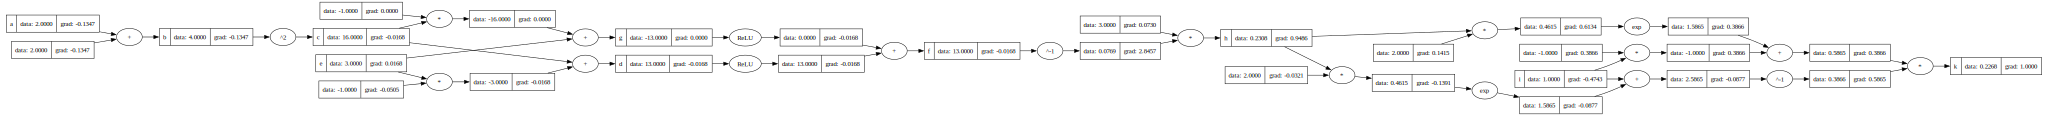

In [116]:
k.zero_grad()
k.grad = 1.0
k.backward()
draw(k)

### 1.4 PyTorch example

Built same example in Pytorch just to be friendly with the main library

In [128]:
a = torch.Tensor([2.0]).double(); a.requires_grad = True
b = a + 2
c = b ** 2
e = torch.Tensor([3.0]).double(); e.requires_grad = True
d = c - e
g = e - c
f = torch.relu(d) + torch.relu(g)
h = 3 / f
i = torch.Tensor([1.0]).double(); i.requires_grad = True
k = ((2*h).exp() - i) / ((2*h).exp() + i)

k.backward()
print(a.grad)
print(e.grad)
print(i.grad)

tensor([-0.1347], dtype=torch.float64)
tensor([0.0168], dtype=torch.float64)
tensor([-0.4743], dtype=torch.float64)


## 2. BUILD MLP

Now Let's build Neurons, Layers and MLP

![Neuron image](neuron.png)

_Neuron_

![Rete neurale](MLP.png)

_Neuran Network_

Digraph example

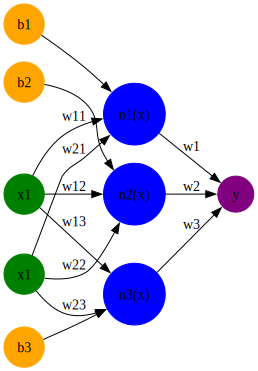

In [35]:
d = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

d.node('x1', label='x1', shape='circle', color='green', style='filled')
d.node('x2', label='x1', shape='circle', color='green', style='filled')
d.node('b1', label='b1', shape='circle', color='orange', style='filled')
d.node('b2', label='b2', shape='circle', color='orange', style='filled')
d.node('b3', label='b3', shape='circle', color='orange', style='filled')
d.node('n1(x)', label='n1(x)', shape='circle', color='blue', style='filled')
d.node('n2(x)', label='n2(x)', shape='circle', color='blue', style='filled')
d.node('n3(x)', label='n3(x)', shape='circle', color='blue', style='filled')
d.node('y', label='y', shape='circle', color='purple', style='filled')

d.edge('x1', 'n1(x)', label='w11')
d.edge('x2', 'n1(x)', label='w21')
d.edge('x1', 'n2(x)', label='w12')
d.edge('x2', 'n2(x)', label='w22')
d.edge('x1', 'n3(x)', label='w13')
d.edge('x2', 'n3(x)', label='w23')
d.edge('b1', 'n1(x)', label='')
d.edge('b2', 'n2(x)', label='')
d.edge('b3', 'n3(x)', label='')

d.edge('n1(x)', 'y', label='w1')
d.edge('n2(x)', 'y', label='w2')
d.edge('n3(x)', 'y', label='w3')
d

### 2.1 Build _Neuron_ class
*with $\tanh$ as activation function and normally (std) randomised parameters $(w_{ij}, b_i \sim \mathcal{N}(0, 1))$

For small MLP is better to use tanh as activation function for the fact that there is no possibility to let a neuron die ($grad = 0.0$)

In [5]:
class Neuron:
    def __init__(self, nin, n_neuron=''):
        self.w = [Value(np.random.randn(), label=f'w{i+1}{n_neuron if isinstance(n_neuron, int) else ''}') for i in range(nin)]
        self.b = Value(np.random.randn(), label=f'b{n_neuron if isinstance(n_neuron, int) else ''}')

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"Neuron({len(self.w)})"

### 2.2 Build _Layer_ class

In [6]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin, i+1) for i in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

### 2.3 Build _MLP_ class

In [7]:
class MLP:
    def __init__(self, sizes):
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]
        self.sizes = sizes

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

_Example_

In [238]:
n = MLP([2,3,1])

x = [
    Value(+2.0, label='x1'), Value(+3.0, label='x2'),
]

n_out = n(x)

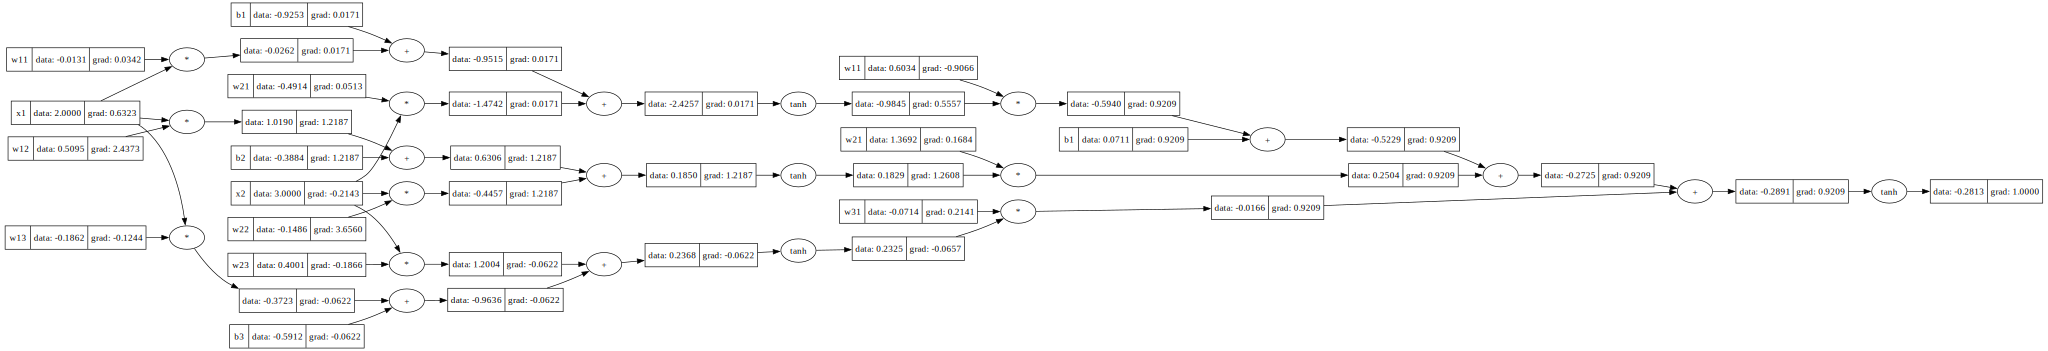

In [239]:
n_out.zero_grad()
n_out.grad = 1.0
n_out.backward()
draw(n_out)

### 2.4 Loss function

In [240]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(-1.0, label='x21'), Value(+4.0, label='x22')],
    [Value(+3.0, label='x31'), Value(-2.0, label='x32')]
]

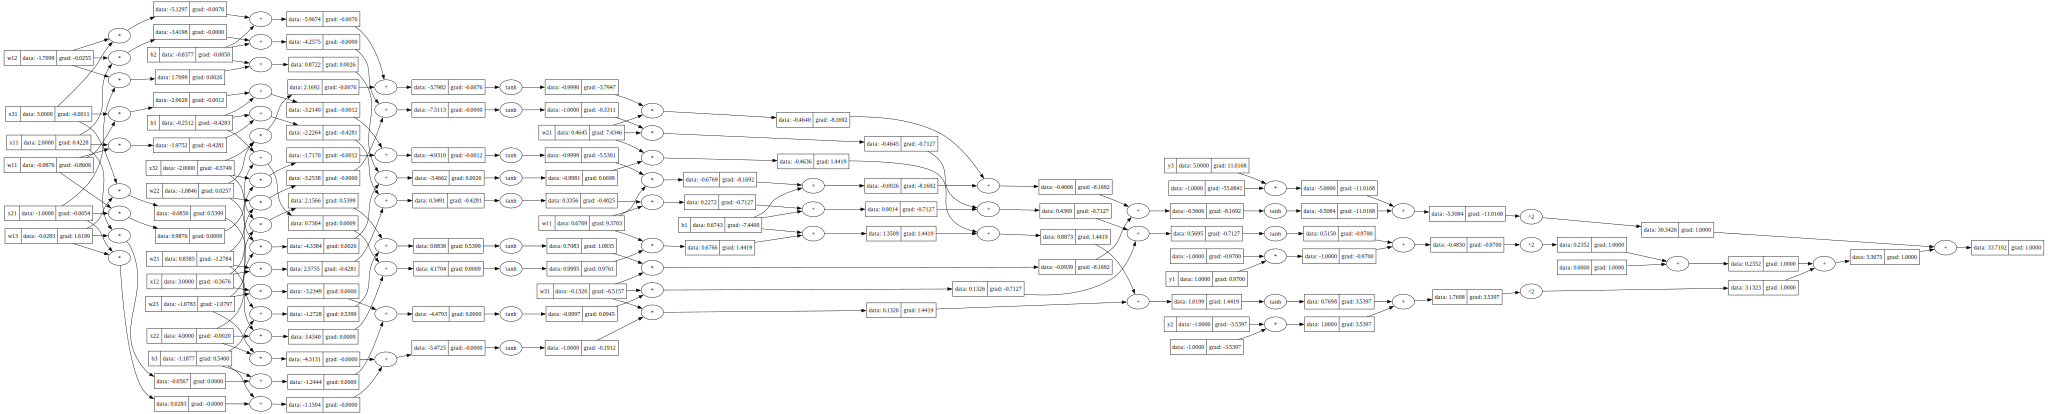

In [241]:
desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(5.0, label='y3')
]
n_outputs = [n(x) for x in xx]
actual_y = [y for y in n_outputs]

loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
loss.zero_grad()
loss.grad = 1.0
loss.backward()
draw(loss)

### 2.5 Visualize a MLP using Digraph

In [128]:
def draw_mlp(mlp: MLP):
    
    d = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # NODES

    for i in range(mlp.sizes[0]):
        d.node(f'x0{i+1}', label=f'x0{i+1}', shape='circle', color='green', style='filled')

    for i in range(len(mlp.sizes) - 2):
        for j in range(mlp.sizes[i+1]):
            d.node(f'b{i}{j+1}', label=f'b{i}{j+1}', shape='circle', color='orange', style='filled')
            d.node(f'n{j+1}(x{i})', label=f'n{j+1}(x{i})', shape='circle', color='blue', style='filled')
    
    for i in range(mlp.sizes[-1]):
        d.node(f'y{i+1}', label=f'y{i+1}', shape='circle', color='purple', style='filled')
        d.node(f'b{len(mlp.sizes)-2}{i+1}', label=f'b{len(mlp.sizes)-2}{i+1}', shape='circle', color='orange', style='filled')

    # EDGES

    for i in range(mlp.sizes[0]):
        for j in range(mlp.sizes[1]):
            d.edge(f'x0{i+1}', f'n{j+1}(x{0})', label=f'w{i+1}{j+1}')
    for j in range(mlp.sizes[1]):
        d.edge(f'b0{j+1}', f'n{j+1}(x{0})')

    for k in range(len(mlp.sizes) - 3):
        for i in range(mlp.sizes[k+1]):
            for j in range(mlp.sizes[k+2]):
                d.edge(f'n{i+1}(x{k})', f'n{j+1}(x{k+1})', label=f'w{i+1}{j+1}')
        for j in range(mlp.sizes[k+2]):
            d.edge(f'b{k+1}{j+1}', f'n{j+1}(x{k+1})')
    
    for i in range(mlp.sizes[-2]):
        for j in range(mlp.sizes[-1]):
            d.edge(f'n{i+1}(x{len(mlp.sizes)-3})', f'y{j+1}', label=f'w{i+1}{j+1}')
    
    for j in range(mlp.sizes[-1]):
        d.edge(f'b{len(mlp.sizes)-2}{j+1}', f'y{j+1}')
    
    return d

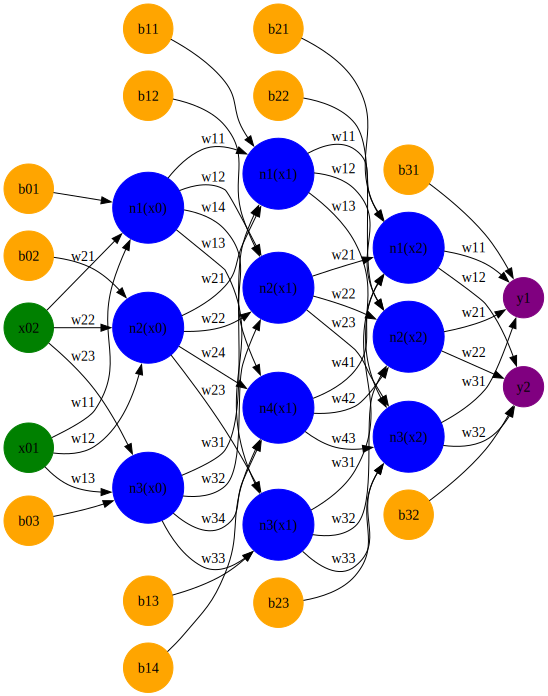

In [134]:
draw_mlp(MLP([2,3,4,3,2]))

### 2.6 How minimize loss function works

In [242]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(-1.0, label='x21'), Value(+4.0, label='x22')],
    [Value(+3.0, label='x31'), Value(-2.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(5.0, label='y3')
]

In [243]:
grads_before = {}
data_before = {}

for p in n.parameters():
    grads_before[p.label] = p.grad
    data_before[p.label] = p.data

for _ in range(3):
    n_outputs = [n(x) for x in xx]
    actual_y = [y for y in n_outputs]

    loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
    loss.zero_grad()
    loss.grad = 1.0
    loss.backward()

    for p in n.parameters():
        p.data -= 0.01 * p.grad
        if np.random.randn() > 0:
            print(f'{p.label:3}: {data_before[p.label]:.5f} -> {p.data:.5f} \t (grad: {grads_before[p.label]:.5f} -> {p.grad:.5f})')
        grads_before[p.label] = p.grad
    print(f'Loss: {loss.data}')

w12: -1.09058 -> -1.05931 	 (grad: 0.00000 -> -3.12649)
b2 : -0.22705 -> -0.21662 	 (grad: 0.00000 -> -1.04213)
w13: 0.29258 -> 0.29390 	 (grad: 0.00000 -> -0.13257)
w23: 1.01754 -> 1.01666 	 (grad: 0.00000 -> 0.08812)
b3 : 0.05914 -> 0.05958 	 (grad: 0.00000 -> -0.04421)
w11: 0.09233 -> 0.11079 	 (grad: -0.05886 -> -1.84526)
w31: 0.07061 -> 0.06016 	 (grad: 0.00000 -> 1.04437)
Loss: 38.91215104977106
b1 : 0.19640 -> -1.09307 	 (grad: -2.08043 -> -0.03756)
w12: -1.09058 -> -1.00656 	 (grad: -3.12649 -> -5.27501)
b2 : -0.22705 -> -0.19904 	 (grad: -1.04213 -> -1.75831)
w13: 0.29258 -> 0.29543 	 (grad: -0.13257 -> -0.15239)
w23: 1.01754 -> 1.01565 	 (grad: 0.08812 -> 0.10136)
b3 : 0.05914 -> 0.06009 	 (grad: -0.04421 -> -0.05081)
w31: 0.07061 -> 0.04533 	 (grad: 1.04437 -> 1.48281)
Loss: 38.574078666000844
w21: 2.17129 -> -1.03427 	 (grad: 2.23422 -> -0.14817)
b1 : 0.19640 -> -1.09258 	 (grad: -2.68668 -> -0.04939)
b2 : -0.22705 -> -0.15690 	 (grad: -1.75831 -> -4.21382)
w11: 0.09233 -> 

### 2.7 Minimize loss function

In [271]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(+3.0, label='x21'), Value(-1.0, label='x22')],
    [Value(-1.0, label='x31'), Value(+1.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(-1.0, label='y3')
]

learning_rate = 0.5

for _ in range(20):
    n_outputs = [n(x) for x in xx]
    actual_y = [y for y in n_outputs]

    loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
    loss.zero_grad()
    loss.grad = 1.0
    loss.backward()

    for p in n.parameters():
        p.data -= learning_rate * p.grad

    print(f'Loss: {loss.data}')

Loss: 4.093448827064745
Loss: 3.9423195003271863
Loss: 3.359063571616691
Loss: 5.144027837082982
Loss: 3.9702057560485713
Loss: 3.96186541781222
Loss: 3.9479294064879555
Loss: 3.920864982907772
Loss: 3.8526252386260613
Loss: 3.558328132803714
Loss: 0.707544688583372
Loss: 1.0749758116614998
Loss: 0.13479490053336038
Loss: 0.011639377191245304
Loss: 0.01052478075729894
Loss: 0.009620879476611877
Loss: 0.00886958958711948
Loss: 0.00823347156837736
Loss: 0.007686899230156995
Loss: 0.0072115732103201265


### 2.8 What happen if I don't update gradient every epoch

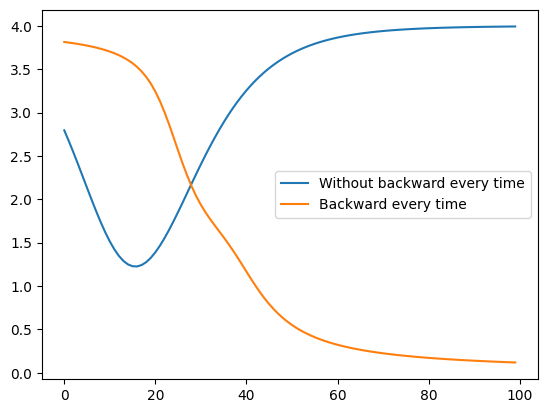

In [124]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(+3.0, label='x21'), Value(-1.0, label='x22')],
    [Value(-1.0, label='x31'), Value(+1.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(-1.0, label='y3')
]

learning_rate = 0.01

losses = [0.0] * 100

initial_parameters = {p.label: p.data for p in n.parameters()}

for i in range(100):
    
    n_outputs = [n(x) for x in xx]
    actual_y = [y for y in n_outputs]
    
    loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
    
    if i == 0:
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()
    
    for p in n.parameters():
        p.data -= learning_rate * p.grad

    losses[i] = loss.data

plt.plot(losses)

for p in n.parameters():
    p.data = initial_parameters[p.label]

for i in range(100):
    
    n_outputs = [n(x) for x in xx]
    actual_y = [y for y in n_outputs]
    
    loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
    
    loss.zero_grad()
    loss.grad = 1.0
    loss.backward()
    
    for p in n.parameters():
        p.data -= learning_rate * p.grad

    losses[i] = loss.data

plt.plot(losses)
plt.legend(['Without backward every time', 'Backward every time'])

### 2.9 What happen when I change learning rate

#### 2.9.1 Learning rate $\eta \leq 0.1$

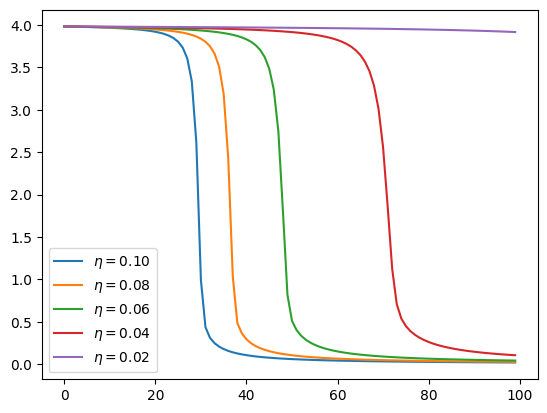

In [128]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(+3.0, label='x21'), Value(-1.0, label='x22')],
    [Value(-1.0, label='x31'), Value(+1.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(-1.0, label='y3')
]

learning_rate_max = 0.1

losses = [0.0] * 100

initial_parameters = {p.label: p.data for p in n.parameters()}

K_MAX = 5

learning_rate = [learning_rate_max * (1 - K_MAX**-1 * k) for k in range(K_MAX)]

for k in range(K_MAX):
    
    for p in n.parameters():
        p.data = initial_parameters[p.label]

    for i in range(100):
        
        n_outputs = [n(x) for x in xx]
        actual_y = [y for y in n_outputs]
        
        loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
        
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()
        
        for p in n.parameters():
            p.data -= learning_rate[k] * p.grad

        losses[i] = loss.data

    plt.plot(losses)

plt.legend([rf'$\eta = {learning_rate[k]:.2f}$' for k in range(K_MAX)])

Image: _eta=0.1.png_

In this case the higher learning rate is the best one. \
Other are too slow.
When $i \approx 48$ $\eta = 0.1$ curve is really close to $0$. \
The same happen in $i \approx 60$ for $\eta = 0.08$ and for $i \approx 80$ for $\eta = 0.06$. \
\
Also analyzing the inflection point with a sharp transaction for every curve (unless for the purple one ($\eta = 0.02$)) is important. \
The product between $\eta$ and $i$ (n. of epochs) when $L \approx 0$ is almost costant. \
\
$0.10 * 48 = 4.8$ \
$0.08 * 60 = 4.8$ \
$0.06 * 80 = 4.8$

Following these hyperbolic correlation it's possible to understand for what epoch $\eta = 0.04$ and $\eta = 0.02$ reach the minimum. \
$\frac{4.8}{0.04} = 120$, $\frac{4.8}{0.02} = 240$

Text(0, 0.5, 'Number of Epochs $\\frac{4.8}{\\eta}$')

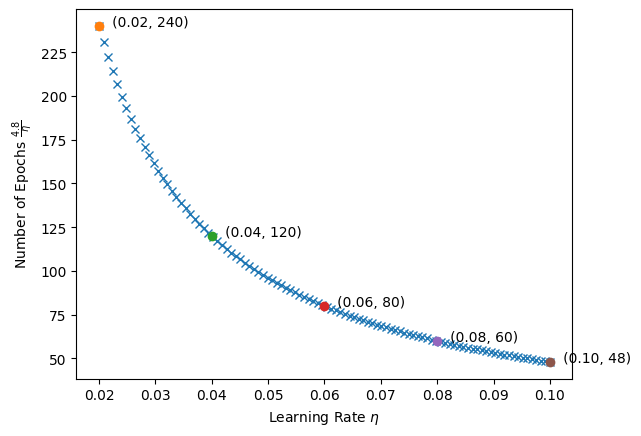

In [183]:
# hyperbolic function x*y = 4.8

eta = np.linspace(0.02, .1, 100)
epoche = 4.8 / eta

plt.plot(eta, epoche, 'x')

for eta_x in [0.02, 0.04, 0.06, 0.08, 0.10]:
    plt.plot(eta_x, 4.8/eta_x, 'o')
    plt.text(eta_x, 4.8/eta_x, f'   ({eta_x:.2f}, {int(4.80001/eta_x)})')

plt.xlabel(r'Learning Rate $\eta$')
plt.ylabel(r'Number of Epochs $\frac{4.8}{\eta}$')

#### 2.9.2 Learning rate $\eta \in \{0.2, 0.4, 0.6, 0.8, 1.0\}$

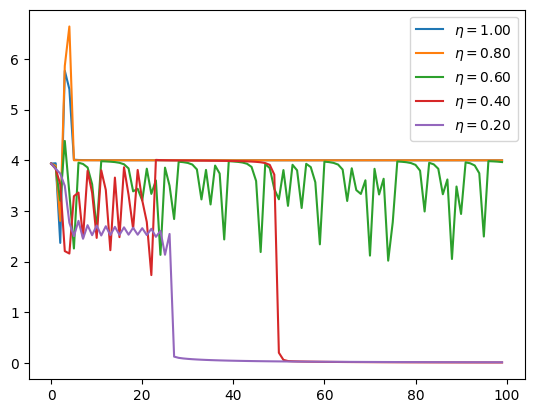

In [146]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(+3.0, label='x21'), Value(-1.0, label='x22')],
    [Value(-1.0, label='x31'), Value(+1.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(-1.0, label='y3')
]

learning_rate_max = 1

losses = [0.0] * 100

initial_parameters = {p.label: p.data for p in n.parameters()}

K_MAX = 5

learning_rate = [learning_rate_max * (1 - K_MAX**-1 * k) for k in range(K_MAX)]

for k in range(K_MAX):
    
    for p in n.parameters():
        p.data = initial_parameters[p.label]

    for i in range(100):
        
        n_outputs = [n(x) for x in xx]
        actual_y = [y for y in n_outputs]
        
        loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
        
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()
        
        for p in n.parameters():
            p.data -= learning_rate[k] * p.grad

        losses[i] = loss.data

    plt.plot(losses)

plt.legend([rf'$\eta = {learning_rate[k]:.2f}$' for k in range(K_MAX)])

Image: _eta=1.png_

In this scenario there are oscillations. \
You can see how $\eta = 0.6$ never reach the global minimun (neither the local one in $4.0$). \
Global Minimum is reached for the first time when $\eta = 0.2$ in the $i \approx 25$ epoch, followed by $\eta = 0.4$ in $i \approx 50$ iteration. \
For $\eta \geq 0.6$ global minimum is never touched. \

In this case $\eta \cdot i \neq K$ constant but the trend is inverted:

$$\frac{i}{\eta} = K$$

$\frac{25}{0.2} = 125$, $\frac{50}{0.4} = 125$

This trend is valid only when learning rate is that tiny so that gradient descent is stable.

#### 2.9.3 Learning rate $\eta \in \{0.1, 0.2, 0.3, 0.4, 0.5\}$

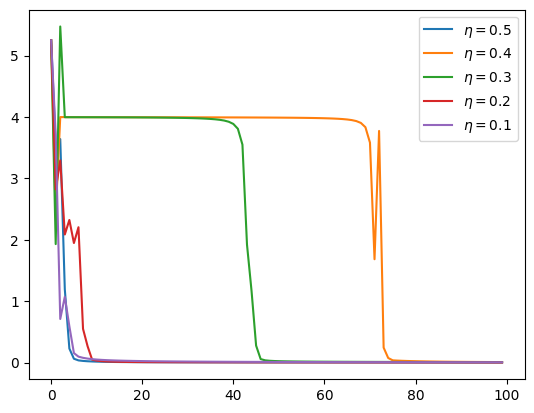

In [157]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(+3.0, label='x21'), Value(-1.0, label='x22')],
    [Value(-1.0, label='x31'), Value(+1.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(-1.0, label='y3')
]

learning_rate_max = 0.5

losses = [0.0] * 100

initial_parameters = {p.label: p.data for p in n.parameters()}

K_MAX = 5

learning_rate = [learning_rate_max * (1 - K_MAX**-1 * k) for k in range(K_MAX)]

for k in range(K_MAX):
    
    for p in n.parameters():
        p.data = initial_parameters[p.label]

    for i in range(100):
        
        n_outputs = [n(x) for x in xx]
        actual_y = [y for y in n_outputs]
        
        loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
        
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()
        
        for p in n.parameters():
            p.data -= learning_rate[k] * p.grad

        losses[i] = loss.data

    plt.plot(losses)

plt.legend([rf'$\eta = {learning_rate[k]:.1f}$' for k in range(K_MAX)])

Image: _eta=0.5.png_

In this scenario there is not a pattern or a trend. \
That's the most common case. In fact, it's nearly impossible to predict the best learning rate. \
(with "best" learning rate I mean the fastest of the stable ones)

### 2.10 Learning rate decay

This is a type of dynamic learning rate.

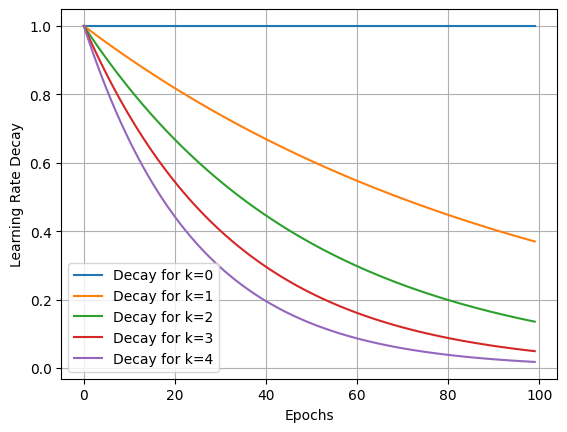

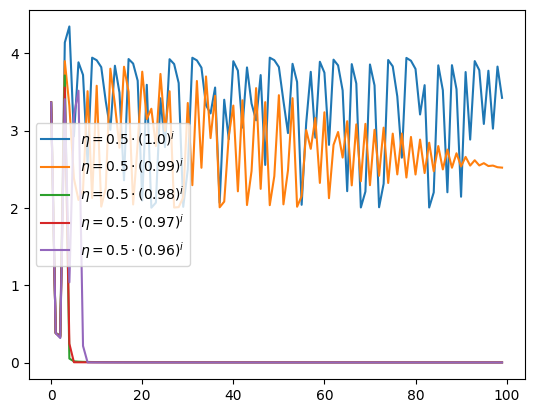

In [ ]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(+3.0, label='x21'), Value(-1.0, label='x22')],
    [Value(-1.0, label='x31'), Value(+1.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(-1.0, label='y3')
]

learning_rate = 0.5

losses = [0.0] * 100

initial_parameters = {p.label: p.data for p in n.parameters()}

K_MAX = 5

decay = [[(1 - 0.01 * k)**i for i in range(100)] for k in range(K_MAX)]

for k in range(K_MAX):
    plt.plot(decay[k], label=f'Decay for k={k}')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate Decay')

plt.legend()
plt.grid()
plt.show()

for k in range(K_MAX):
    
    for p in n.parameters():
        p.data = initial_parameters[p.label]

    for i in range(100):
        
        n_outputs = [n(x) for x in xx]
        actual_y = [y for y in n_outputs]
        
        loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
        
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()
        
        for p in n.parameters():
            p.data -= learning_rate * decay[k][i] * p.grad

        losses[i] = loss.data

    plt.plot(losses)

plt.legend([rf'$\eta = {learning_rate:.1f} \cdot ({1 - 0.01 * k:.2f})^i$' for k in range(K_MAX)])

Image: _decay_stabilize_training.png_

Given the initial condition (parameters' values of MLP) $\eta = 0.5$ learning rate is too high (so instable).\
It's easily visible that in this determinated conditions having a small learning rate decay coefficient $(\leq 0.97)$ help to reach the stability of the training.

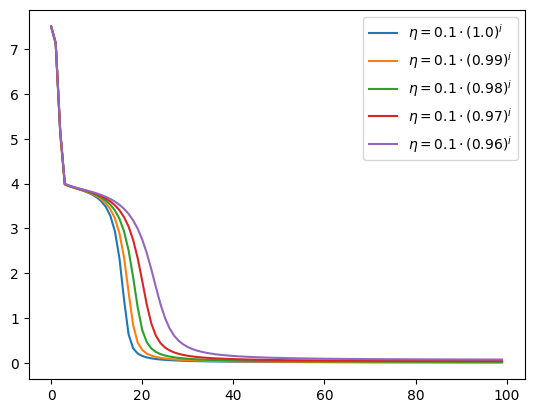

In [230]:
n = MLP([2,3,1])

xx = [
    [Value(+2.0, label='x11'), Value(+3.0, label='x12')],
    [Value(+3.0, label='x21'), Value(-1.0, label='x22')],
    [Value(-1.0, label='x31'), Value(+1.0, label='x32')]
]

desired_y = [
    Value(1.0, label='y1'), Value(-1.0, label='y2'), Value(-1.0, label='y3')
]

learning_rate = 0.05

losses = [0.0] * 100

initial_parameters = {p.label: p.data for p in n.parameters()}

K_MAX = 5

decay = [[(1 - 0.01 * k)**i for i in range(100)] for k in range(K_MAX)]

for k in range(K_MAX):
    
    for p in n.parameters():
        p.data = initial_parameters[p.label]

    for i in range(100):
        
        n_outputs = [n(x) for x in xx]
        actual_y = [y for y in n_outputs]
        
        loss = sum((act - des)**2 for act, des in zip(actual_y, desired_y))
        
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()
        
        for p in n.parameters():
            p.data -= learning_rate * decay[k][i] * p.grad

        losses[i] = loss.data

    plt.plot(losses)

plt.legend([rf'$\eta = {learning_rate:.1f} \cdot ({1 - 0.01 * k})^i$' for k in range(K_MAX)])

Image: _decay_slow_down_training.png_

Instead, when initial condition are different, a small decay coeff. can slow down the training (more epoch to minimize the loss $L$)

### 2.11 Adaptive Learning Rate

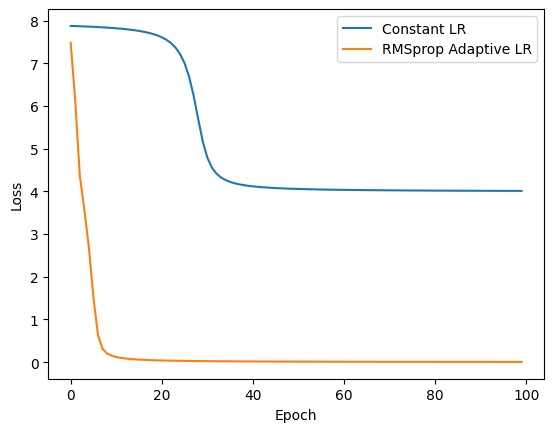

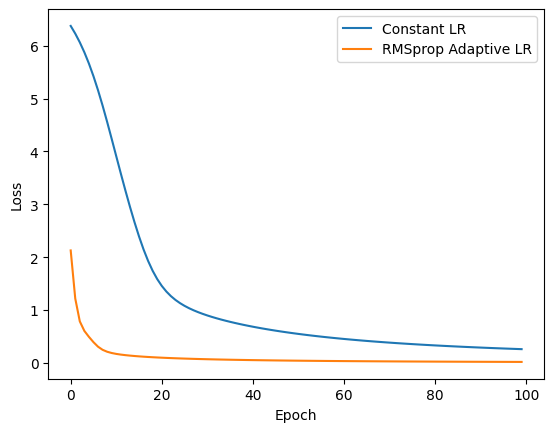

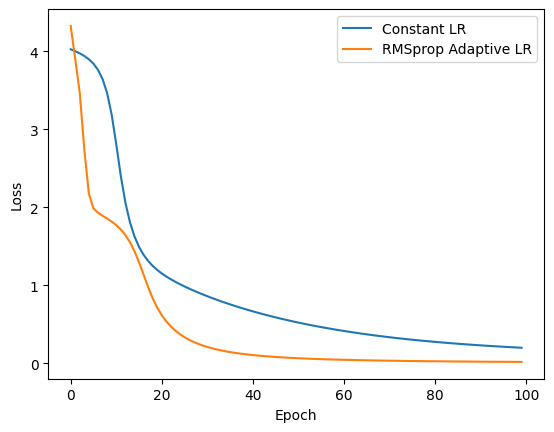

In [246]:
for _ in range(3):

    n = MLP([2, 3, 1])

    # Hyperparameters
    base_lr = 0.01
    eps = 1e-8      # Epsilon for numerical stability (prevents division by zero)
    rho = 0.99      # Decay rate for the moving average of squared gradients

    initial_parameters = {p.label: p.data for p in n.parameters()}

    epochs = 100
    losses = [0.0] * epochs

    for i in range(epochs):
        # 1. Forward Pass
        n_outputs = [n(x) for x in xx]
        loss = sum((act - des)**2 for act, des in zip(n_outputs, desired_y))
        losses[i] = loss.data

        # 2. Backward Pass
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()

        # 3. Update Parameters    
        for p in n.parameters():
            p.data -= base_lr * p.grad

    plt.plot(losses, label='Constant LR')


    ### WITH ADAPTIVE LEARNING RATE

    for p in n.parameters():
        p.data = initial_parameters[p.label]

    # Hyperparameters
    base_lr = 0.01
    eps = 1e-8      # Epsilon for numerical stability (prevents division by zero)
    rho = 0.99      # Decay rate for the moving average of squared gradients

    # State initialization: squared gradient cache for each parameter
    cache = {p: 0.0 for p in n.parameters()}

    initial_parameters = {p.label: p.data for p in n.parameters()}

    epochs = 100
    losses = [0.0] * epochs

    for i in range(epochs):
        # 1. Forward Pass
        n_outputs = [n(x) for x in xx]
        loss = sum((act - des)**2 for act, des in zip(n_outputs, desired_y))
        losses[i] = loss.data

        # 2. Backward Pass
        loss.zero_grad()
        loss.grad = 1.0
        loss.backward()

        # 3. RMSprop Update (Adaptive Step Size)
        for p in n.parameters():
            # Accumulate the squared gradient: E[g^2]_t = rho * E[g^2]_{t-1} + (1-rho) * g_t^2
            cache[p] = rho * cache[p] + (1 - rho) * p.grad**2
            
            # Compute the adaptive update: theta = theta - (lr / sqrt(E[g^2] + eps)) * g
            adaptive_lr = base_lr / (cache[p]**.5 + eps)
            p.data -= adaptive_lr * p.grad

    plt.plot(losses, label='RMSprop Adaptive LR')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()